In [1]:
import argparse, os, time
import pandas as pd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
donors_csv = "./output/donors20_pred_lastname.csv"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,name,name_new,orgname,ultorg,gender,occupation,employer,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,"FOR AMERICA, AMY",amy for america,[24T Contribution],NaN,,NOT EMPLOYED,NOT EMPLOYED,1.261253e+09,25821,4.884603e+04,1000.0,for america,not
1,U00000037041,"BLOOMBERG, MICHAEL",michael bloomberg,Bloomberg LP,NaN,M,MAYOR,CITY OF NEW YORK,1.127731e+09,958,1.177172e+06,682.5,bloomberg,not
2,U00000036521,"STEYER, THOMAS F",thomas f steyer,Fahr LLC/Tom Steyer,Fahr LLC,M,FOUNDER,NEXTGEN AMERICA,3.794782e+08,756,5.019553e+05,2800.0,steyer,not
3,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,M,INVESTMENTS,SELF,4.513356e+07,23,1.962328e+06,2800.0,mellon,not
4,U0000000310A,"ADELSON, MIRIAM O DR",miriam o dr adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,F,PHYSICIAN,ADELSON CLINIC,4.499955e+07,124,3.628996e+05,2800.0,adelson,not
5,U00000003101,"ADELSON, SHELDON G MR",sheldon g mr adelson,Las Vegas Sands,NaN,M,CHAIRMAN OF THE BOARD,THE VENETIAN,4.484795e+07,119,3.768735e+05,2800.0,adelson,not
6,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M,NaN,NaN,3.536433e+07,319,1.108600e+05,2800.0,uihlein,not
7,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Rodimer for Congress,NaN,M,FOUNDER CEO,CITADEL LLC,3.366763e+07,188,1.790832e+05,2800.0,griffin,not
8,U00000003611,"SCHWARZMAN, STEPHEN A",stephen a schwarzman,Blackstone Group,NaN,M,"CHAIRMAN, CEO & CO-FOUNDER",BLACKSTONE,3.345400e+07,226,1.480265e+05,2800.0,schwarzman,not
9,U00000046781,"JURVETSON, KARLA",karla jurvetson,[24T Contribution],NaN,F,PHYSICIAN,SELF,3.308810e+07,914,3.620142e+04,2800.0,jurvetson,not


In [4]:
donors[donors["ethnic"] == "ind"].sort_values(by="total_donated", ascending=False).head(10)

,contrib_id,name,name_new,orgname,ultorg,gender,occupation,employer,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
74,U00000040581,"ANWAR, SYED J",syed j anwar,Midland Energy,NaN,M,CEO,MIDLAND ENERGY INC,3859124.0,195,19790.379487,2800.0,anwar,ind
91,U00000047321,"KIANI, JOE",joe kiani,[24T Contribution],NaN,M,CEO,MASIMO,3317175.0,131,25321.946565,4000.0,kiani,ind
125,U00000045761,"ANSARY, HUSHANG",hushang ansary,[24T Contribution],NaN,M,CHARIMAN,PARMAN CAPITAL GROUP,2689195.0,172,15634.854651,2800.0,ansary,ind
149,U00000033011,"KHOSLA, VINOD",vinod khosla,Khosla Ventures,NaN,M,VENTURE CAPITALIST,KHOSLA VENTURES LLC,2410795.0,56,43049.910714,2224.0,khosla,ind
213,U00000045811,"MANOCHERIAN, JED",jed manocherian,Woodbranch Investments,NaN,M,DIRECTOR,WOODBRANCH INVESTMENTS,1841362.0,265,6948.535849,2800.0,manocherian,ind
234,U00000045762,"ANSARY, SHAHLA",shahla ansary,Parman Capital Group,NaN,F,HOMEMAKER,NaN,1749091.0,78,22424.243590,9200.0,ansary,ind
264,m0001327150,"GANDHI, SAMEER",sameer gandhi,Accel Partners,NaN,M,VENTURE CAPITALIST,ACCEL,1629499.0,110,14813.627273,10000.0,gandhi,ind
340,i30032161751,"CHANDI, NACHHATTAR",nachhattar chandi,Chandi Group Usa,NaN,M,OWNER,CHANDI GROUP USA,1311745.0,104,12612.932692,1572.5,chandi,ind
346,c01704896561,"QAZI, MOHAMMAD MR",mohammad mr qazi,Ciena Healthcare Management,NaN,M,FOUNDER,CIENA HEALTHCARE MANAGEMENT,1303500.0,88,14812.500000,5000.0,qazi,ind
349,h10013502001,"REDDY, PREM",prem reddy,Prime Healthcare Services,NaN,M,FOUNDER/CHIEF EXECUTIVE OFFICER,PRIME HEALTHCARE SERVICES,1297700.0,59,21994.915254,10000.0,reddy,ind


In [6]:
print(donors["total_donated"].sum())
print(donors[donors["ethnic"] == "ind"]["total_donated"].sum())
print((donors[donors["ethnic"] == "ind"]["total_donated"].sum()/donors["total_donated"].sum())*100, "% of donated amount is from diaspora")

12004197961.0
107836072.0
0.8983196740868875 % of donated amount is from diaspora


In [7]:
print(len(donors))
print(len(donors[donors["ethnic"] == "ind"]))
print((len(donors[donors["ethnic"] == "ind"])/len(donors))*100, "% of donors are from diaspora")

3588936
23138
0.6447036113210155 % of donors are from diaspora


In [8]:
print(donors["donation_count"].median())
print(donors[donors["ethnic"] == "ind"]["donation_count"].median())

3.0
2.0


In [9]:
print(donors["total_donated"].median())
print(donors[donors["ethnic"] == "ind"]["total_donated"].median())

432.0
550.0


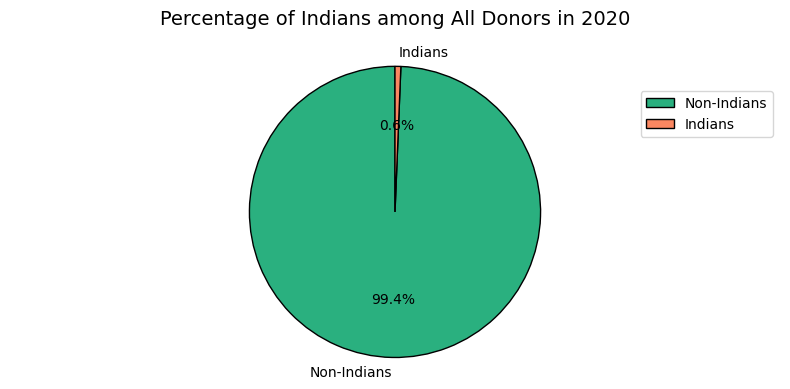

In [10]:
indian_counts = donors['ethnic'].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(indian_counts, 
        labels=['Non-Indians', 'Indians'], 
        colors=['#2ab07f', '#fb8761'], 
        autopct='%1.1f%%', 
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        textprops={'fontsize': 10})

plt.title('Percentage of Indians among All Donors in 2020', pad=20, fontsize=14)
plt.axis('equal')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

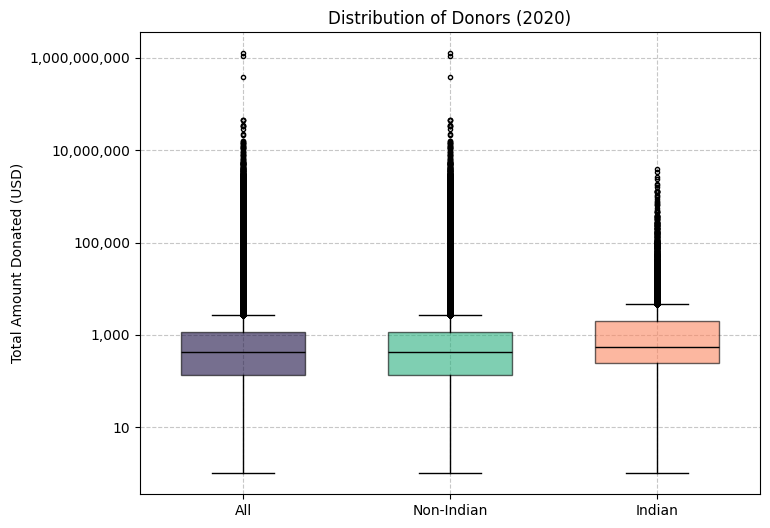

In [11]:
amounts_all = donors['total_donated']
amounts_non_indian = donors[donors['ethnic'] == "not"]['total_donated']
amounts_indian = donors[donors['ethnic'] == "ind"]['total_donated']

plt.figure(figsize=(8, 6))
plot = plt.boxplot([amounts_all, amounts_non_indian, amounts_indian], 
                   tick_labels=["All", "Non-Indian", "Indian"], 
                   patch_artist=True, 
                   widths=0.6, 
                   medianprops={"color": "black", "linewidth": 1}, 
                   flierprops={"marker": "o", "markersize": 3})

colors = ["#1b1044", "#2ab07f", "#fb8761"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donors (2020)")
plt.ylabel("Total Amount Donated (USD)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

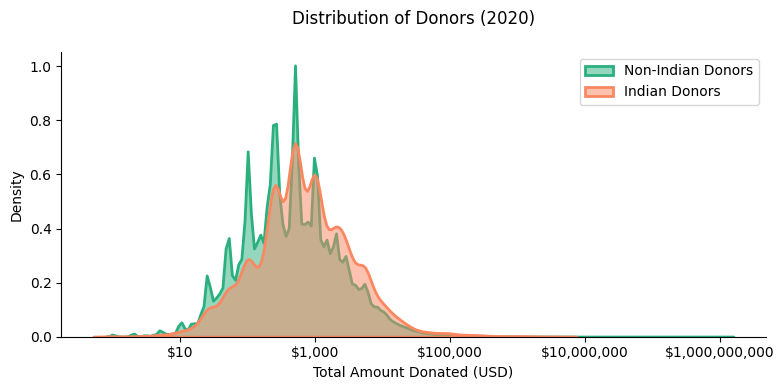

In [12]:
plt.figure(figsize=(8, 4))

sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
][donors['ethnic'] == "not"]['total_donated'],
            label='Non-Indian Donors',
            color='#2ab07f',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)
sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
][donors['ethnic'] == "ind"]['total_donated'],
            label='Indian Donors',
            color='#fb8761',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)

plt.title("Distribution of Donors (2020)", pad=20)
plt.xlabel("Total Amount Donated (USD)")
plt.ylabel("Density")
plt.xscale('log')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()